<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/best%20channel/1%20ch(40.%20T7).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
'''
1 channel :  T7 (index =40)

layers: 3 conv2D(3,3) & maxpooling(2,2)
epoch: 20 
batch size: 20

test acc: 0.8378
test loss: 0.6504

'''


import matplotlib
from matplotlib import pyplot as plt
import numpy as np


import random
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
#from mne.datasets import testing
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)


1 channel :  T7 (index =40)

layers: 3 conv2D(3,3) & maxpooling(2,2)
epoch: 20 
batch size: 20

test acc: 0.
test loss: 0.




In [1]:
!pip install mne

In [4]:
subject_number=20


# load dataset in array
list_raw_fnames = [[0]*2]*subject_number
for x in range(subject_number):
    list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,[1,2])

list_rawdata1 = np.zeros((subject_number,2), dtype='object')
list_rawdata = np.zeros((subject_number,2), dtype='object')

for i in range(subject_number):
    for j in range(2):
        list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)
       

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extr

In [5]:
import math


task_number=1
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
sample_shift = 4 #step len
window_len= 20
list_channel = [40] # channel = T7

# img for each one
subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec) / sample_shift) +1 - window_len +1
test_start_index=subject_img_number - math.floor(subject_img_number/4) 

train_number =  test_start_index 
test_number = subject_img_number - test_start_index
train_number

1757

In [6]:
ch_number = len(list_channel)

train_img = np.zeros((train_number*subject_number, ch_number, window_len + 1, 160), dtype = float)
train_label =[]


test_img = np.zeros((test_number*subject_number, ch_number, window_len, 160), dtype = float)
test_label =[]


train_img.shape


(35140, 1, 21, 160)

In [0]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

In [0]:
for s in range(subject_number):
    ch_max =[]
    ch_min =[]
    for ch in list_channel:
      rawdataChannels_t, times_t =list_rawdata[s][0][ch,:9600]
      #print(rawdataChannels_t)
      ch_max = np.append(ch_max, max(rawdataChannels_t[0])) # max for each cannel
      ch_min = np.append(ch_min, min(rawdataChannels_t[0])) # min for each cannel
    
    for j in range (subject_img_number):
        i = 0
        for index in list_channel: # فقط کانال های با اندیس مشخص را دربرمیگیرد
            
            for z in range (window_len):
                rawdataChannels, times =list_rawdata[s][0][index, (j+z)*sample_shift:sampel_number_per_sec+(j+z)*sample_shift]

                      # normalize method
                rawdataChannels = normalize_channel_data(rawdataChannels, i, ch_min, ch_max)
                if j <test_start_index :
                    train_img[s*train_number + j][i][z] = rawdataChannels
                    if z==window_len-1 :
                      train_img[s*train_number + j][i][z+1] = s
                      
                      
                else:
                    test_img[s*test_number + j - test_start_index][i][z] = rawdataChannels
            i+=1            
                    
              
        if j >=test_start_index :
          test_label = np.append(test_label, (s))

In [0]:
#shaffle train img array
train_img_shuffle = train_img

np.random.shuffle(train_img_shuffle)

In [0]:
train_img_2 = np.zeros((train_number*subject_number, ch_number, window_len, 160), dtype = float)

# img label 
train_img_shuffle_len =len(train_img_shuffle)
for i in range(train_img_shuffle_len):
    train_label = np.append(train_label, (train_img_shuffle[i][0][window_len][0] ))
    for j in range (ch_number):
      train_img_2[i][j] = np.delete(train_img_shuffle[i][j], window_len, axis=0)

In [11]:
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
train_label = to_categorical(train_label, subject_number)
test_label = to_categorical(test_label, subject_number)

In [13]:
# valid & train
x_train =train_img_2[:20000]
y_train =train_label[:20000]

x_valid =train_img_2[20000:]
y_valid =train_label[20000:]

x_valid.shape

(15140, 1, 20, 160)

In [28]:
train_label[:10]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0.]], dtype=float32)

In [14]:
from keras import layers
from keras import models
from keras import regularizers


model = models.Sequential()
model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape = (ch_number,window_len,160), data_format= "channels_first" ))
print(model.output.shape)
model.add(layers.MaxPooling2D((2,2)))
print(model.output.shape)
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
print(model.output.shape)
model.add(layers.MaxPooling2D((2,2)))
print(model.output.shape)
model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
print(model.output.shape)
model.add(layers.MaxPooling2D((2,2)))


model.add(layers.Flatten())
print(model.output.shape)
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.5))
print(model.output.shape)
model.add(layers.Dense(subject_number, activation = 'softmax'))
print(model.output.shape)




from keras import optimizers

model.compile(loss= 'categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr= 1e-4),
              metrics = ['acc'])

W0822 15:00:47.813513 140213244774272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 15:00:47.852300 140213244774272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0822 15:00:47.859521 140213244774272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0822 15:00:47.874524 140213244774272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0822 15:00:47.875615 1402132447

(?, 64, 20, 160)
(?, 32, 10, 160)
(?, 30, 8, 128)
(?, 15, 4, 128)
(?, 13, 2, 256)
(?, ?)
(?, 512)
(?, 20)


In [15]:
history = model.fit(
        x_train,
        y_train,
        epochs = 20,
        batch_size = 20,
        validation_data = (x_valid, y_valid)
)

W0822 15:00:53.372484 140213244774272 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 20000 samples, validate on 15140 samples
Epoch 1/20
20000/20000 [==============================] - 12s 577us/step - loss: 2.4207 - acc: 0.2211 - val_loss: 1.5094 - val_acc: 0.5164
Epoch 2/20
20000/20000 [==============================] - 9s 441us/step - loss: 1.3396 - acc: 0.5292 - val_loss: 0.9307 - val_acc: 0.6950
Epoch 3/20
20000/20000 [==============================] - 9s 441us/step - loss: 0.9605 - acc: 0.6573 - val_loss: 0.8563 - val_acc: 0.7014
Epoch 4/20
20000/20000 [==============================] - 9s 444us/step - loss: 0.7354 - acc: 0.7348 - val_loss: 0.7496 - val_acc: 0.7061
Epoch 5/20
20000/20000 [==============================] - 9s 445us/step - loss: 0.6288 - acc: 0.7727 - val_loss: 0.4413 - val_acc: 0.8413
Epoch 6/20
20000/20000 [==============================] - 9s 443us/step - loss: 0.5516 - acc: 0.7972 - val_loss: 0.4828 - val_acc: 0.8170
Epoch 7/20
20000/20000 [==============================] - 9s 444us/step - loss: 0.5047 - acc: 0.8159 - val_loss: 0.3460 -

In [16]:
model.evaluate(test_img, test_label)


11700/11700 [==============================] - 1s 128us/step


[0.6504155033955696, 0.8378632478632478]

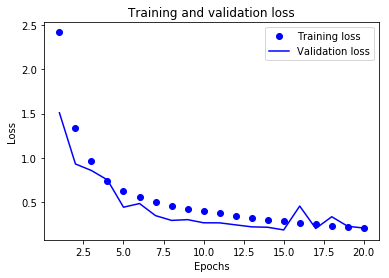

In [17]:
import matplotlib.pyplot as plt

history_dict = history.history 

loss_values = history_dict ['loss'] 

val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)



plt.plot(epochs, loss_values, 'bo', label='Training loss') 

plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 

plt.title('Training and validation loss') 

plt.xlabel('Epochs') 

plt.ylabel('Loss') 

plt.legend()

plt.show()

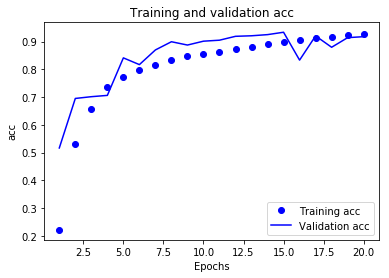

In [18]:
history_dict = history.history 

acc_values = history_dict ['acc'] 

val_acc_values = history_dict['val_acc']



plt.plot(epochs, acc_values, 'bo', label='Training acc') 

plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 

plt.title('Training and validation acc') 

plt.xlabel('Epochs') 

plt.ylabel('acc') 

plt.legend()

plt.show()